In [1]:
library(Seurat)
library(SingleCellExperiment)
library(dplyr)
library(ggplot2)
library(miloR)
library(patchwork)

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Warning message:
“package ‘SingleCellExperiment’ was built under R version 4.3.2”
Loading required package: SummarizedExperiment

Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.3.2”
Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.2”
Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabul

In [2]:
male = readRDS("/data/ZhanglabShare/Nhlh2_progject/Nhlh2.neuron.v2.91479cells.rds")
male <- subset(x=male,  sex == "Male")
male = subset(x = male, batch2 == "WT_Male_1",invert = T)
table(male$batch2)


CKO_Male_1 CKO_Male_2  WT_Male_2 
      7518       8320       5159 

In [3]:
male$celltype <- droplevels(male$celltype)

In [4]:
table(male$celltype)


   Agrp   Avp-1   Avp-2   Cck-1   Cck-2   Cdh12      DA Gm10800 Gm20754 Gm28035 
    196    1621     194    1157     331    3080     125    1084    1501     198 
Gm45455 Gm49337    Hap1    Hcrt    Isl1   Kiss1   Nr5a1 Onecut1  Schip1     Sst 
   2096    1178    1914     118    2528      78    1098     514    1699     287 

In [5]:
male.sce <- as.SingleCellExperiment(male)

In [6]:
male_milo <- Milo(male.sce)

Constructing kNN graph with k:20

Checking valid object

Running refined sampling with reduced_dim



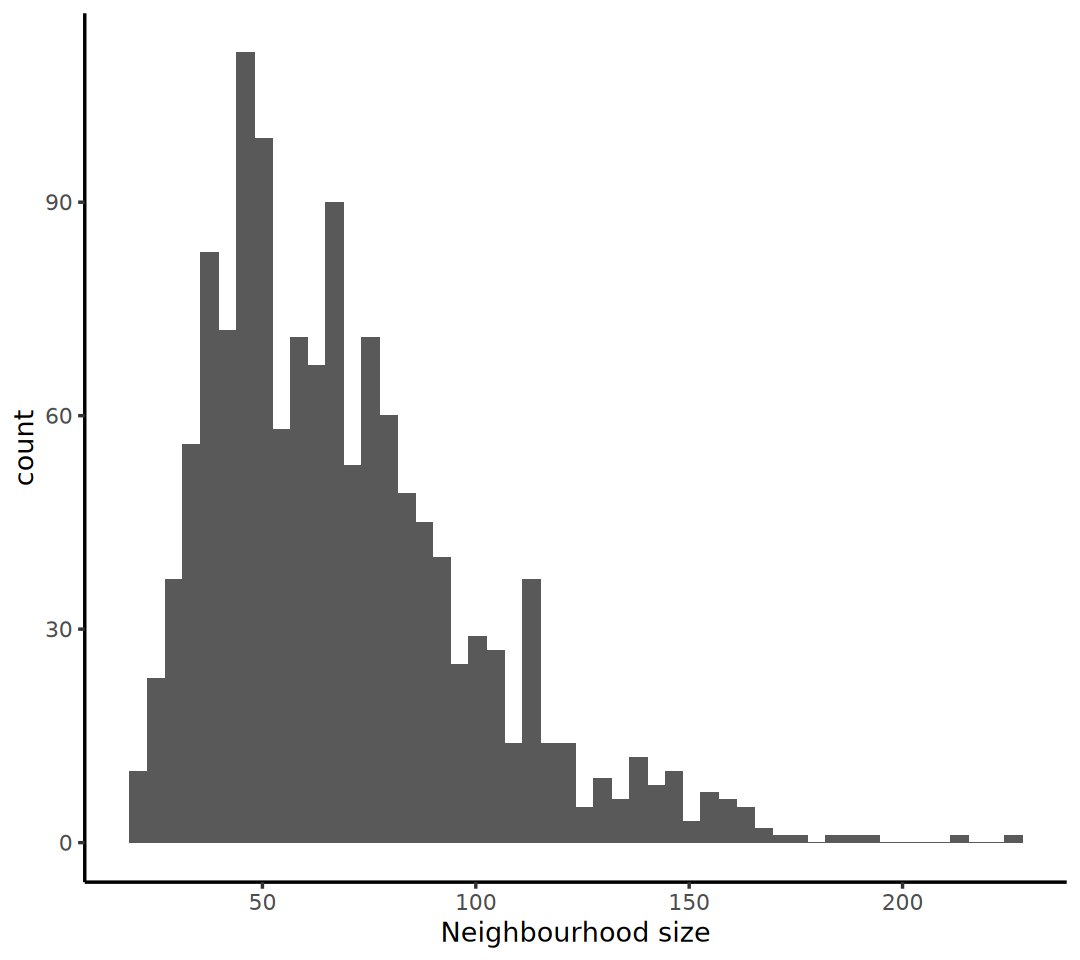

In [46]:
male_milo <- buildGraph(male_milo, k = 20, d = 30)
male_milo <- makeNhoods(male_milo, prop = 0.1, k = 20, d= 30, refined = TRUE)
options(repr.plot.width=9, repr.plot.height=8)
plotNhoodSizeHist(male_milo)

In [47]:
male_milo <- countCells(male_milo, meta.data = data.frame(colData(male_milo)), samples="batch2")
head(nhoodCounts(male_milo))

Checking meta.data validity

Counting cells in neighbourhoods



6 x 3 sparse Matrix of class "dgCMatrix"
  CKO_Male_1 CKO_Male_2 WT_Male_2
1         42         52         .
2         11         10        13
3         48         49        22
4         41         38        24
5         55         41        25
6         27         22        17

In [48]:
design <- data.frame(colData(male_milo))[,c("batch2", "treatment")]
design <- distinct(design)
rownames(design) <- design$batch2
## Reorder rownames to match columns of nhoodCounts(milo)
design <- design[colnames(nhoodCounts(male_milo)), , drop=FALSE]
design

,batch2,treatment
,<chr>,<chr>
CKO_Male_1,CKO_Male_1,CKO
CKO_Male_2,CKO_Male_2,CKO
WT_Male_2,WT_Male_2,WT


In [62]:
male_milo <- calcNhoodDistance(male_milo, d=30)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



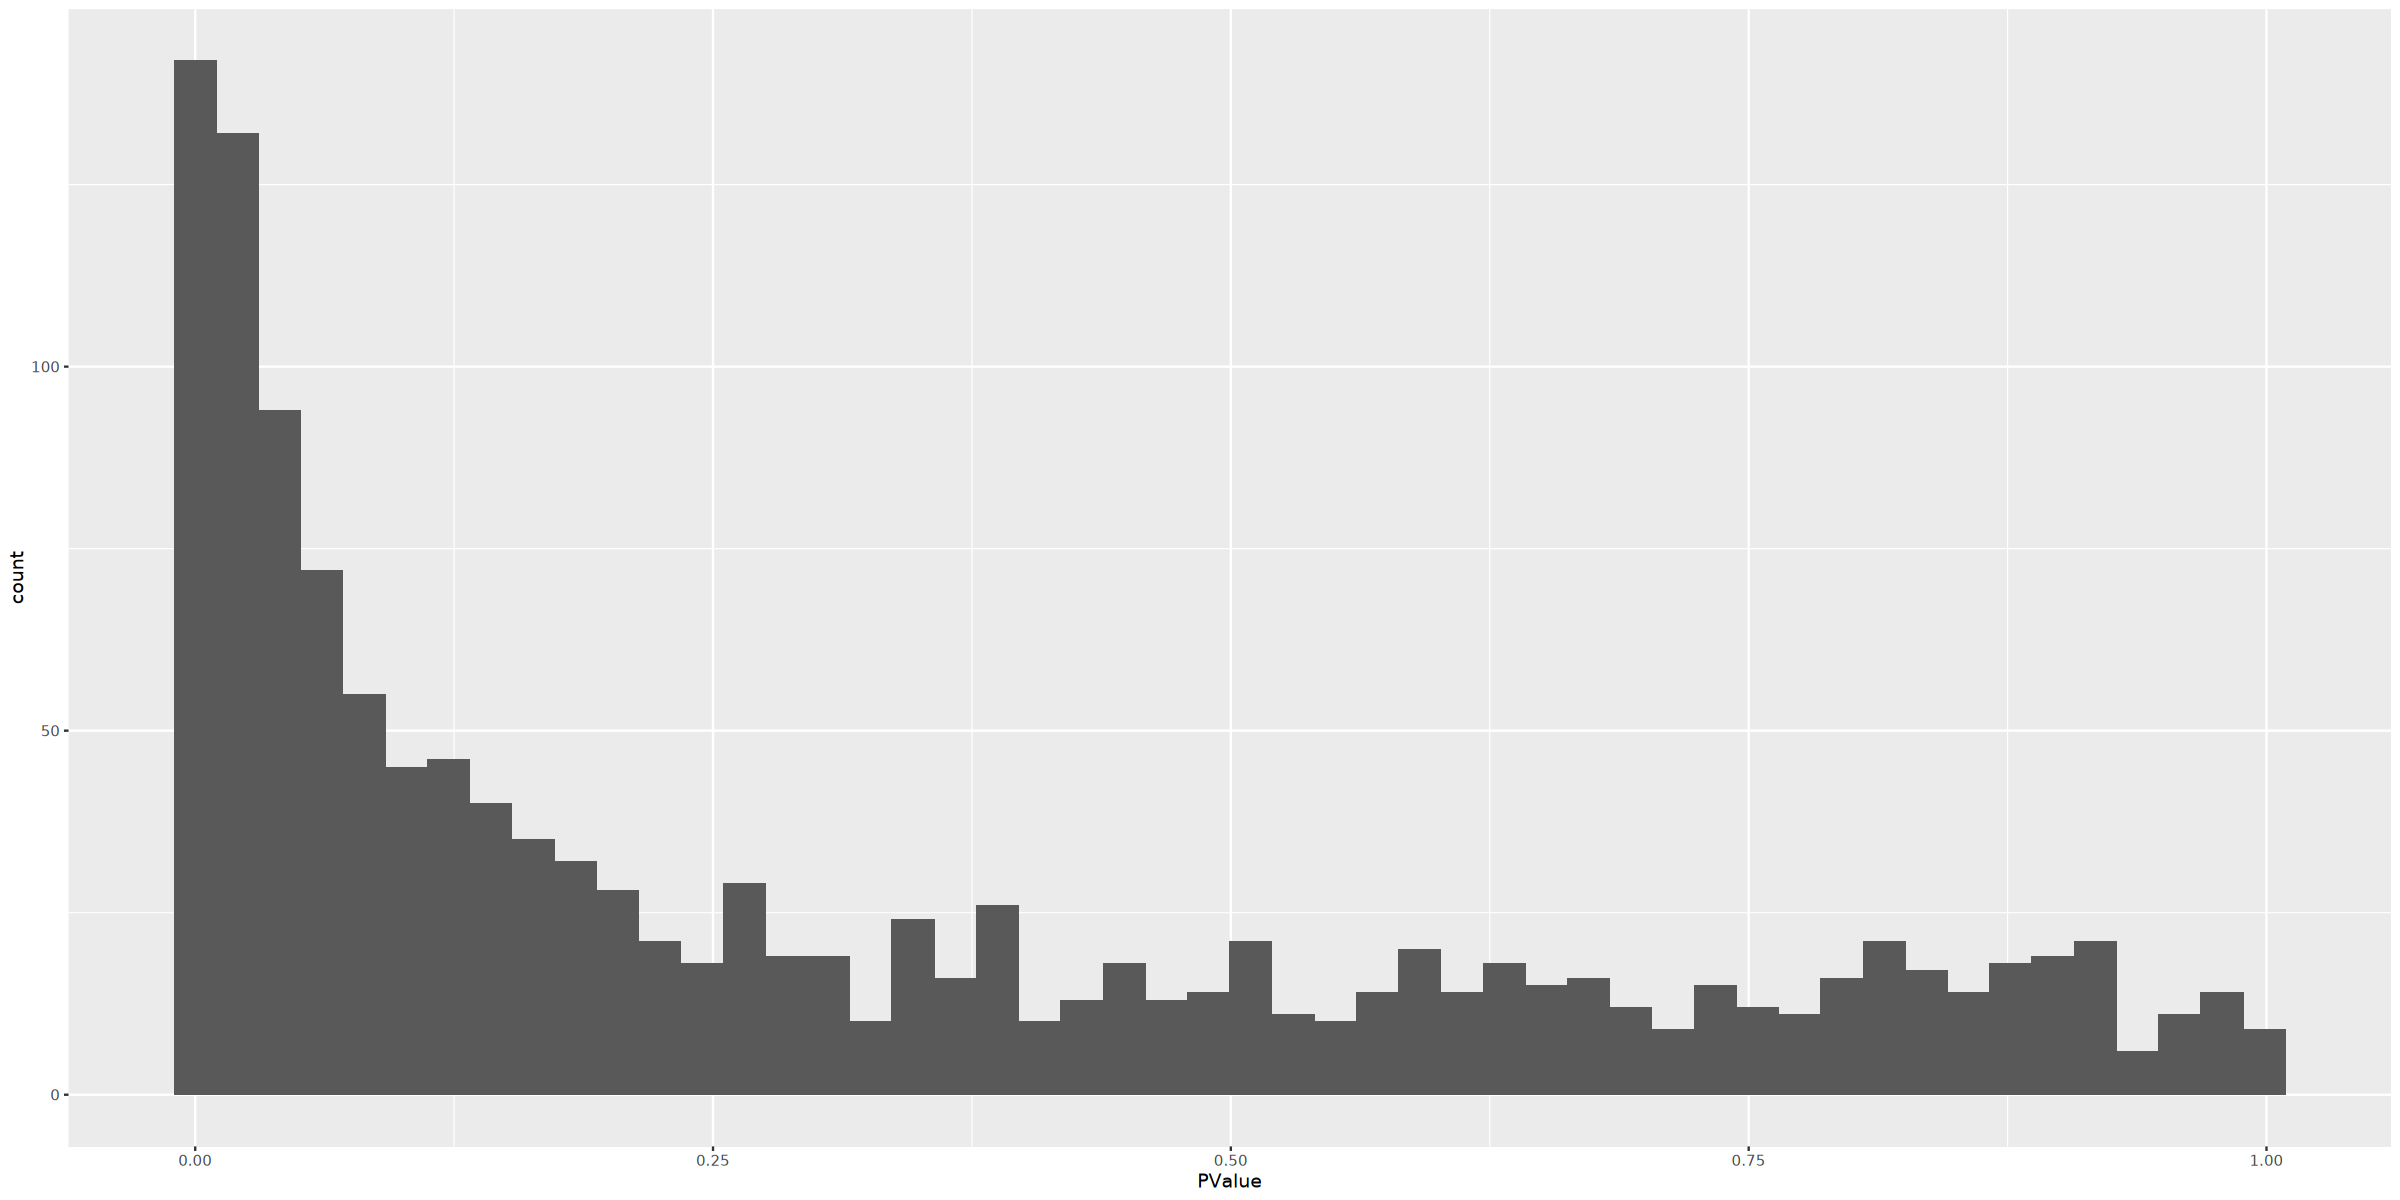

In [63]:
da_results <- testNhoods(male_milo, design = ~ treatment, design.df = design)
ggplot(da_results,aes(PValue))+geom_histogram(bins = 50)

In [64]:
da_results <- annotateNhoods(male_milo, da_results, coldata_col = "celltype")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,celltype,celltype_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-8.309629573,10.006577,6.632231e+01,0.0008738784,0.0609920,1,0.06806355,Avp-1,0.9787234
2,1.231046650,8.788663,9.211710e+00,0.0331281460,0.1511263,2,0.15686556,Nr5a1,0.7352941
3,-0.205262364,10.393694,4.148632e-01,0.5508488746,0.7281022,3,0.73315768,Isl1,0.9915966
4,0.215054931,10.215482,5.065553e-01,0.5121774116,0.6934654,4,0.69958280,Isl1,0.7961165
5,-0.006261826,10.425610,2.913407e-04,0.9871392100,0.9944236,5,0.99512550,Hap1,0.2975207
6,0.405304972,9.621512,1.279916e+00,0.3166232897,0.5104977,6,0.51680571,Gm49337,0.9393939


In [65]:
male_milo <- buildNhoodGraph(male_milo)

Converting group_by to factor...



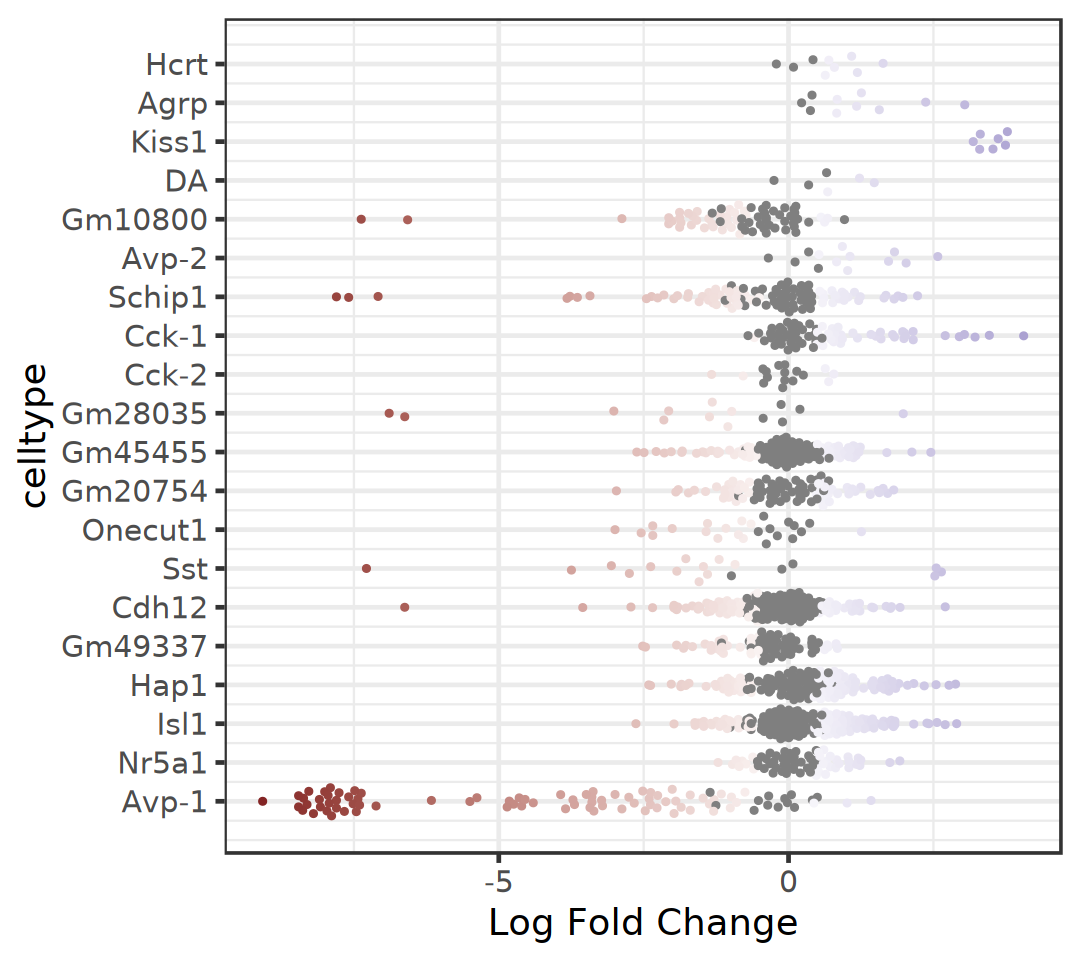

In [66]:
options(repr.plot.width=9, repr.plot.height=8)
plotDAbeeswarm(da_results, group.by = "celltype",alpha = 0.4)

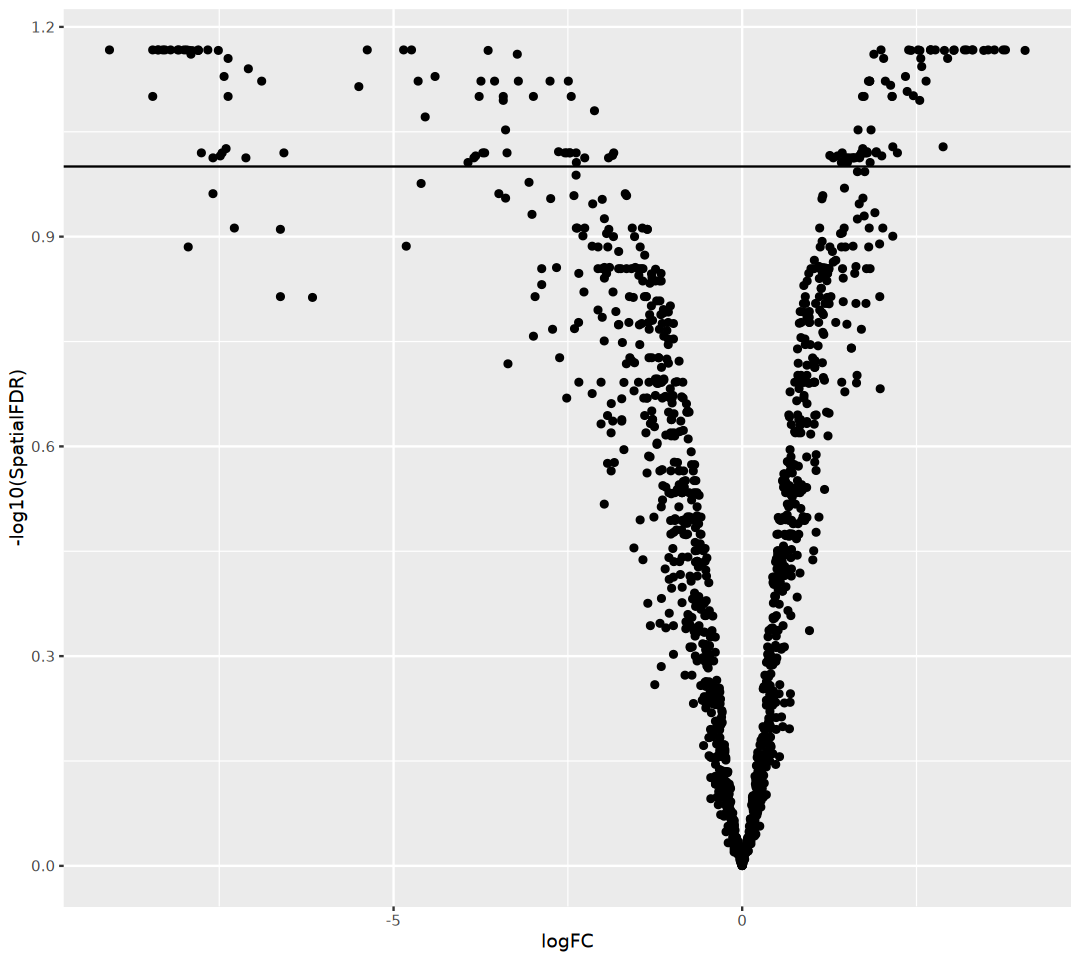

In [67]:
ggplot ( da_results , aes ( logFC , - log10 ( SpatialFDR ))) +
   geom_point () +
   geom_hline ( yintercept  =  1 ) ## 标记显着性阈值（10% FDR）

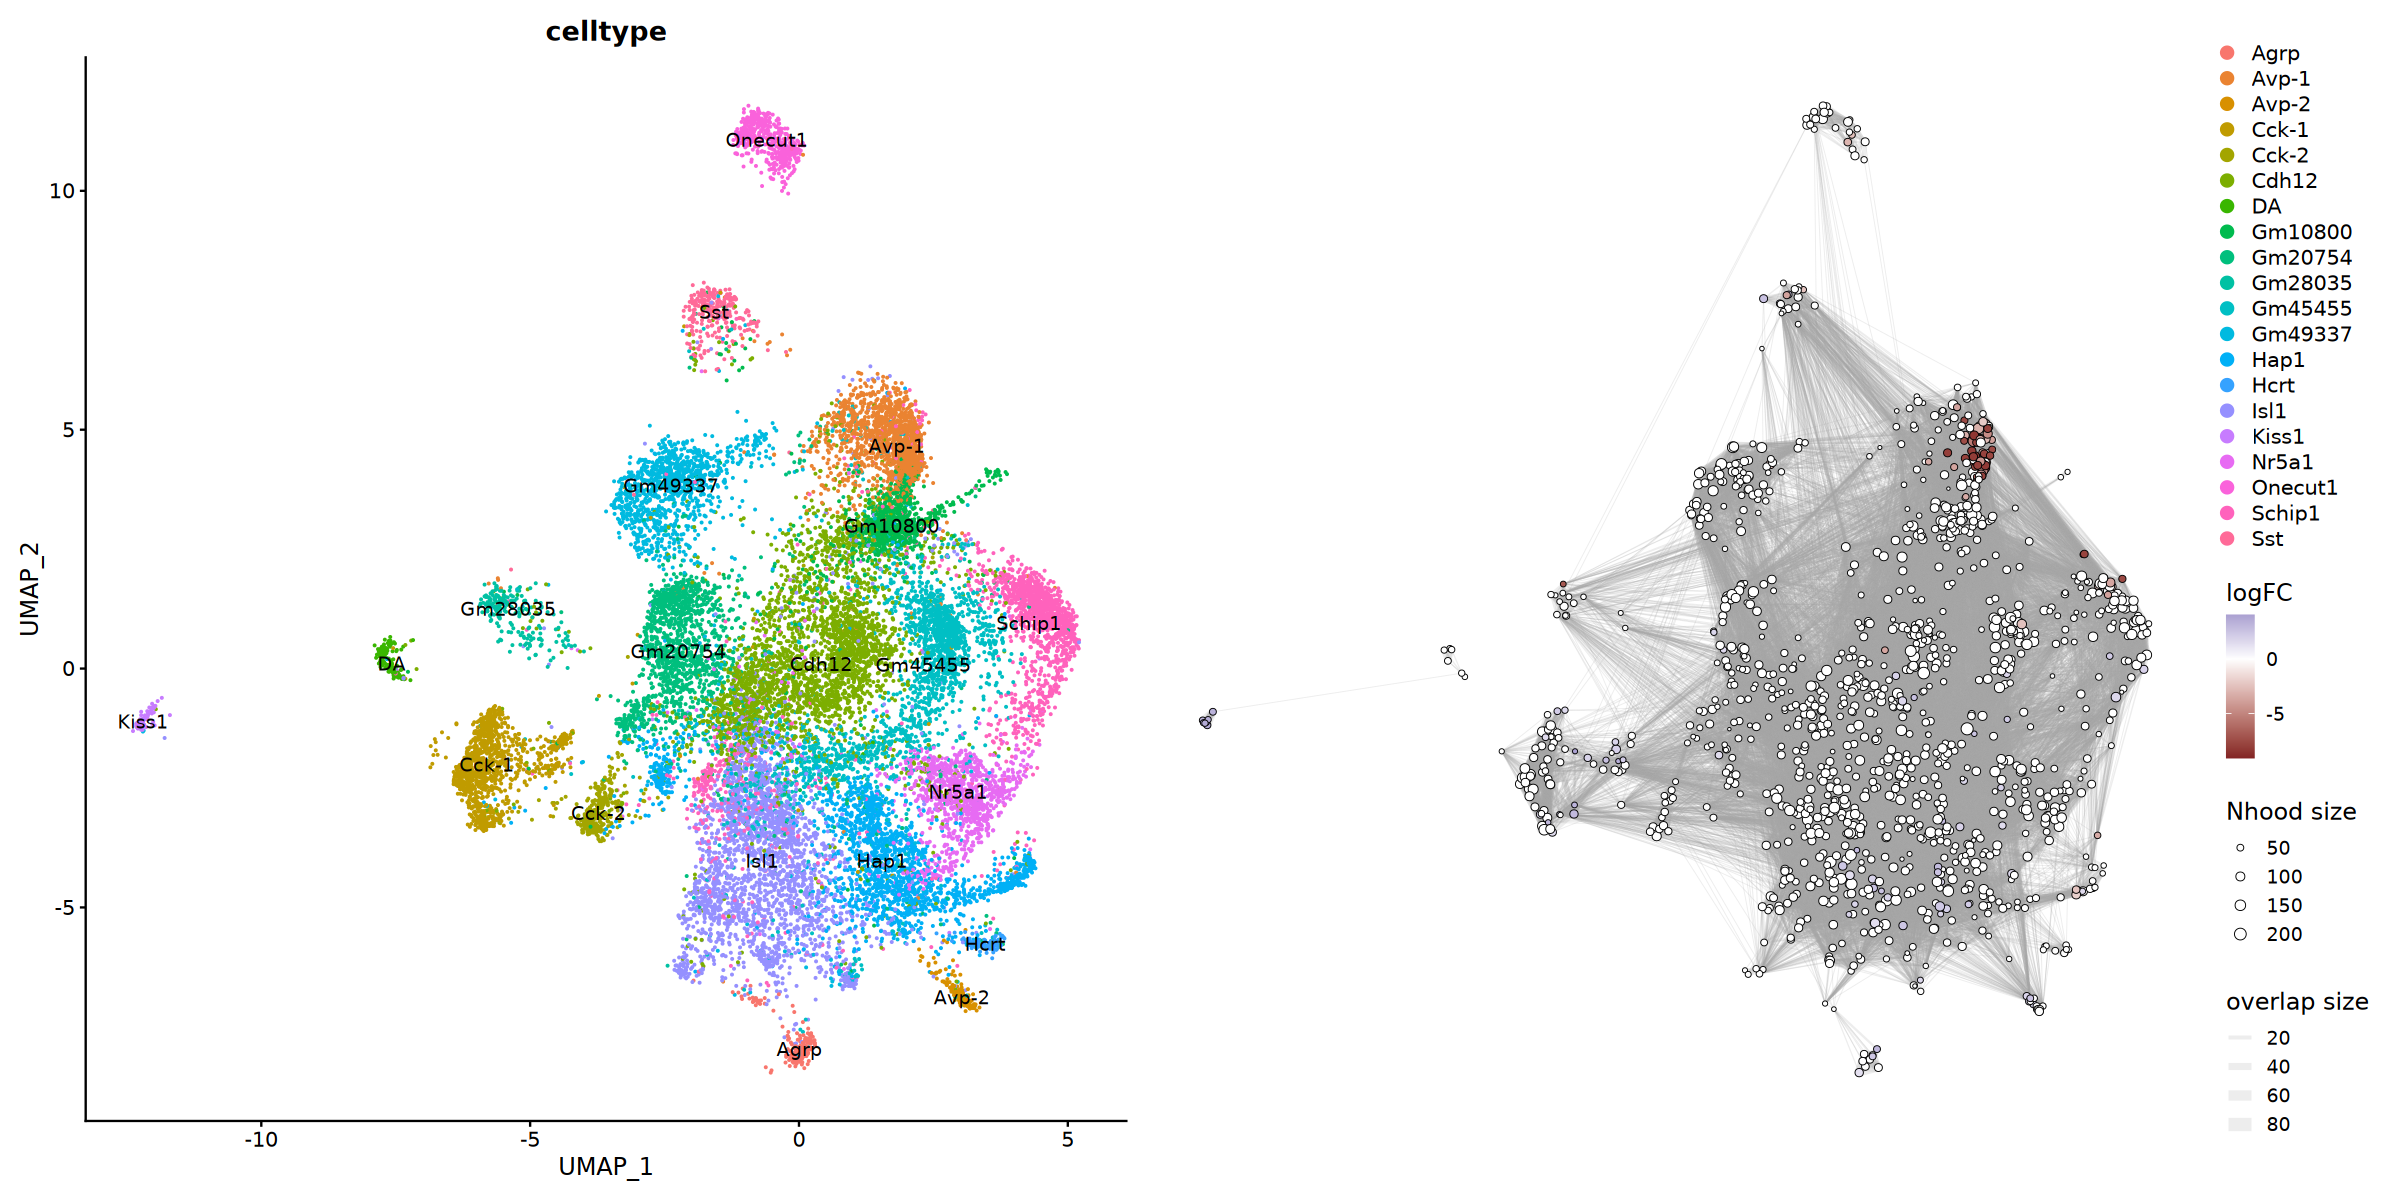

In [68]:
male_milo <- buildNhoodGraph(male_milo)
umap_pl <- DimPlot(male,group.by='celltype',label = T) +
  guides(fill="none")

## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(male_milo, da_results,alpha=0.1)
options(repr.plot.width=20, repr.plot.height=10)
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [17]:
female <- readRDS("/data/ZhanglabShare/Nhlh2_progject/female.neuron.v2.26268cells.rds")

In [18]:
female.sce <- as.SingleCellExperiment(female)

Constructing kNN graph with k:20

Checking valid object

Running refined sampling with reduced_dim



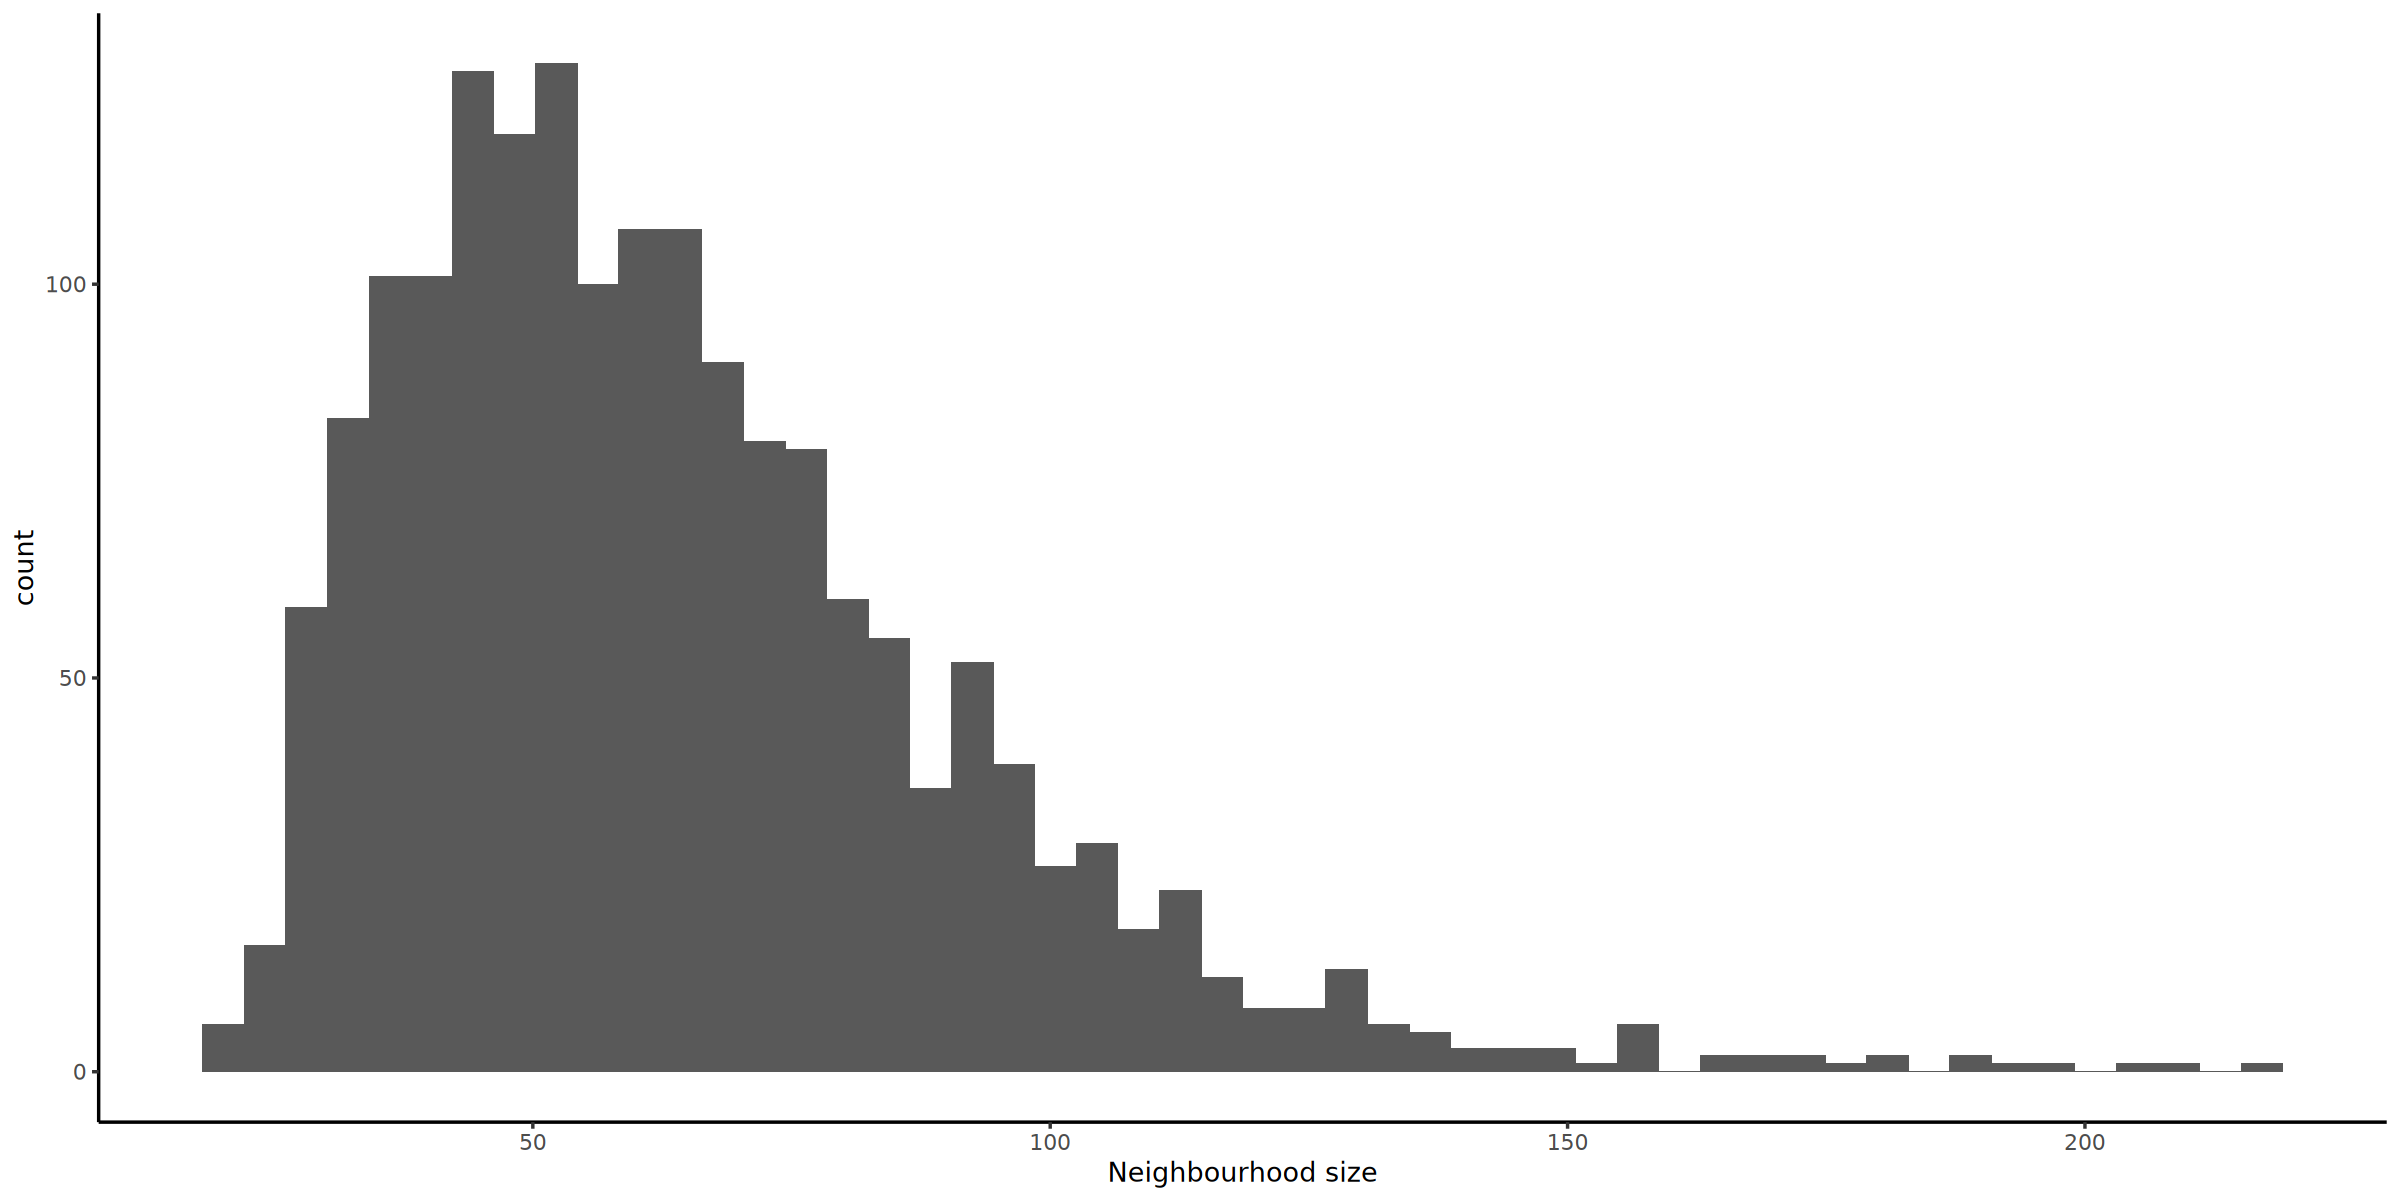

In [19]:
female_milo <- Milo(female.sce)
female_milo <- buildGraph(female_milo, k = 20, d = 30)
female_milo <- makeNhoods(female_milo, prop = 0.1, k = 20, d=30, refined = TRUE)
plotNhoodSizeHist(female_milo)

In [71]:
female_milo <- countCells(female_milo, meta.data = data.frame(colData(female_milo)), samples="batch2")
head(nhoodCounts(female_milo))
design <- data.frame(colData(female_milo))[,c("batch2", "treatment")]
design <- distinct(design)
rownames(design) <- design$batch2
## Reorder rownames to match columns of nhoodCounts(milo)
design <- design[colnames(nhoodCounts(female_milo)), , drop=FALSE]

design

Checking meta.data validity

Counting cells in neighbourhoods



6 x 4 sparse Matrix of class "dgCMatrix"
  CKO_Female_1 CKO_Female_2 WT_Female_1 WT_Female_2
1           13           24          27          25
2           20           33          29          21
3            1           11           3          12
4           12           36          26          23
5            3           11          30          51
6            7           14          14          14

,batch2,treatment
,<chr>,<chr>
CKO_Female_1,CKO_Female_1,CKO
CKO_Female_2,CKO_Female_2,CKO
WT_Female_1,WT_Female_1,WT
WT_Female_2,WT_Female_2,WT


In [72]:
female_milo <- calcNhoodDistance(female_milo, d=30)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



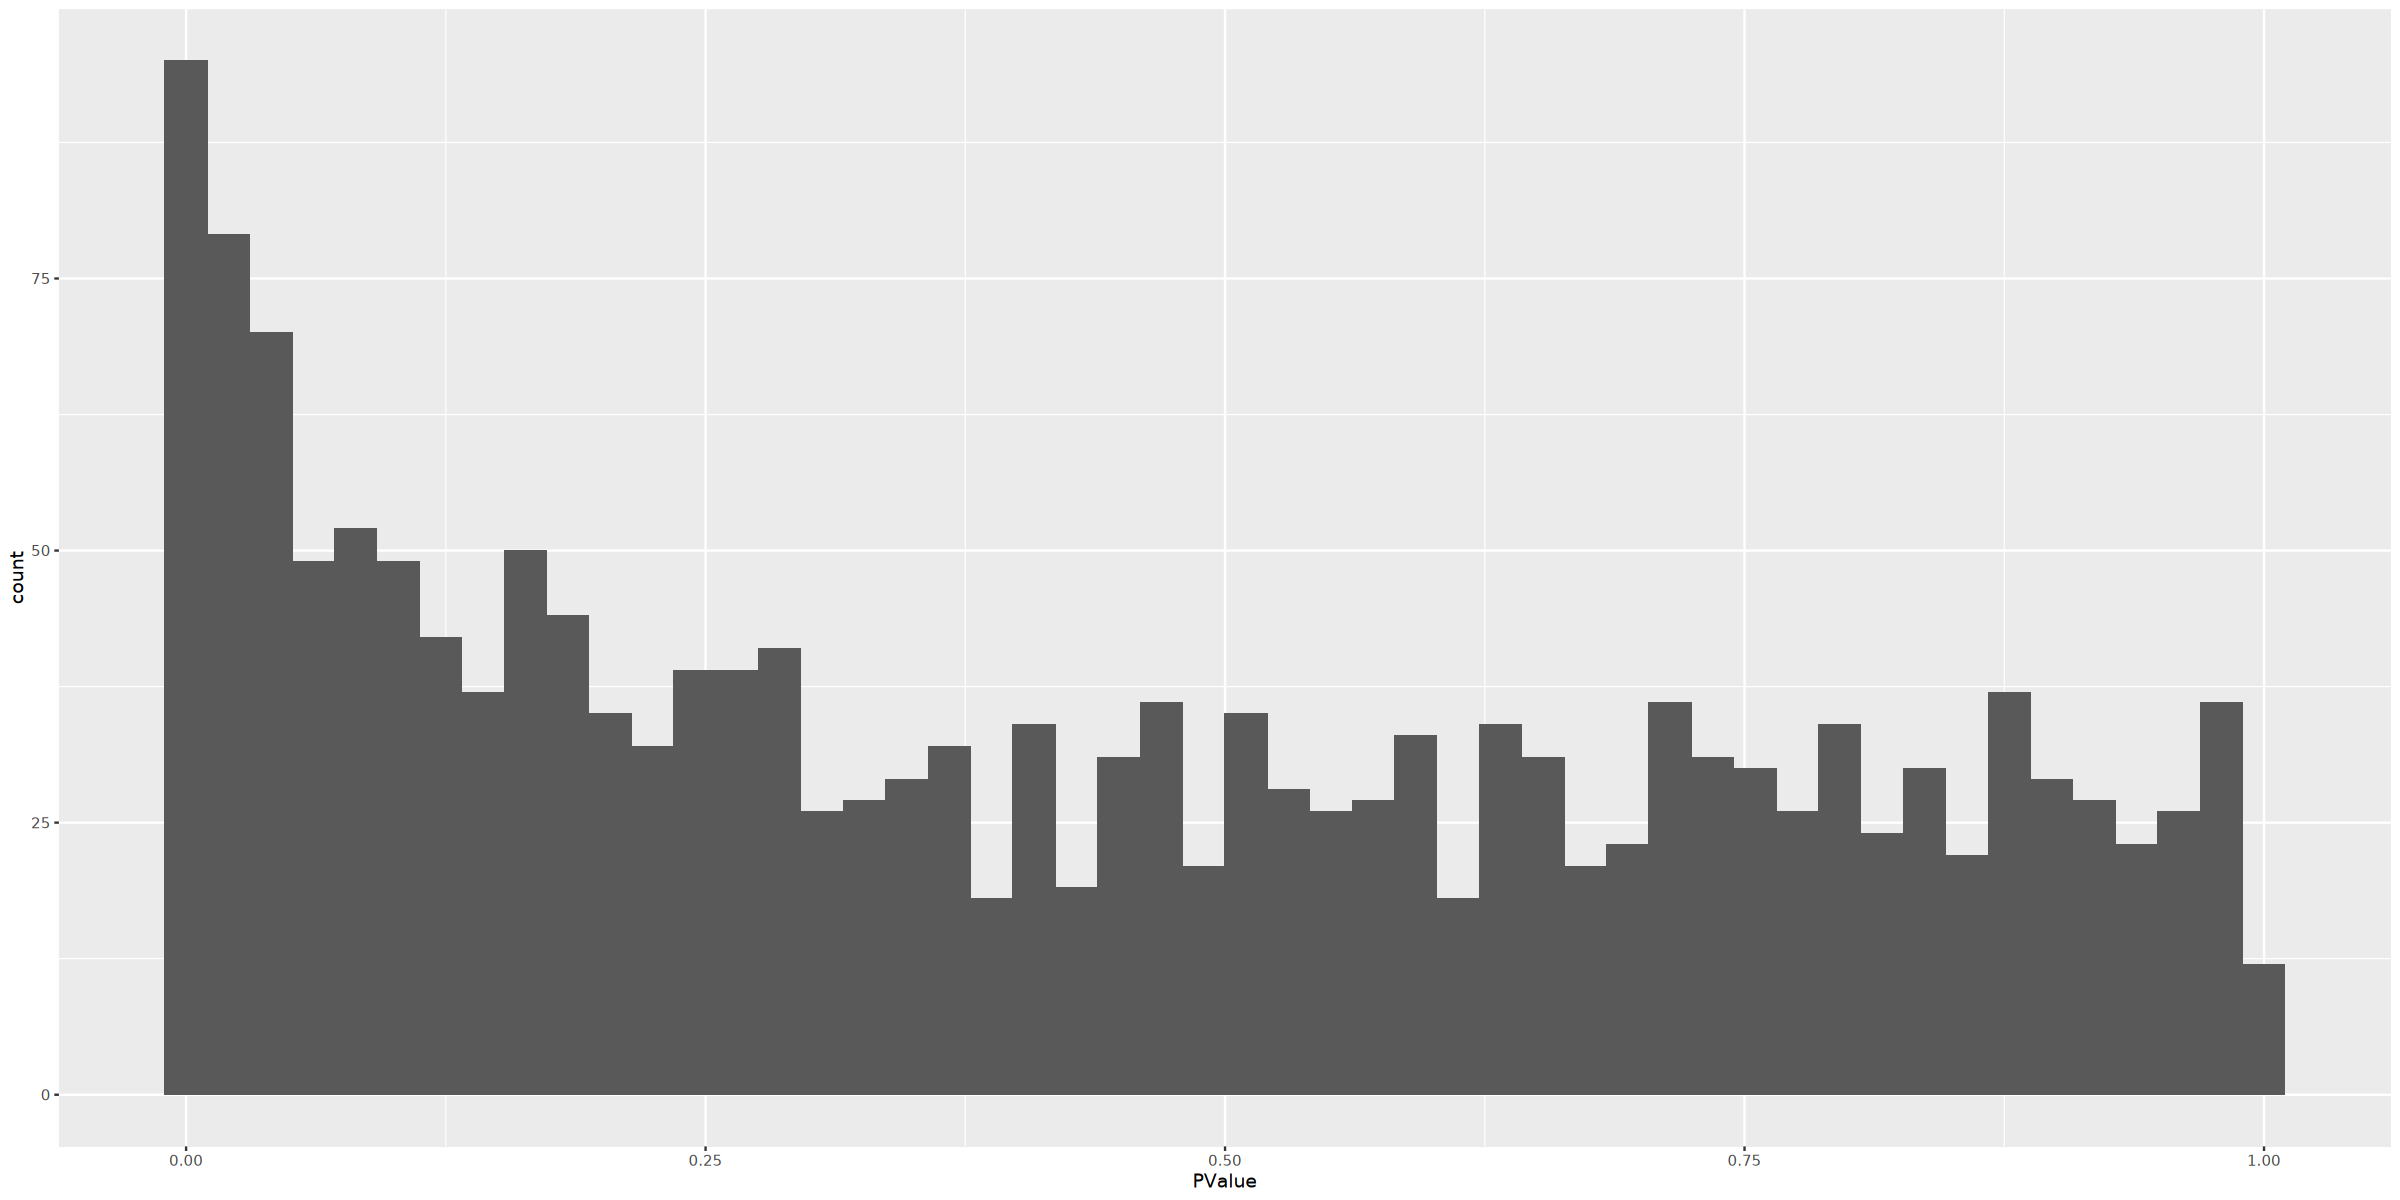

In [75]:
da_results <- testNhoods(female_milo, design = ~ treatment, design.df = design)
ggplot(da_results,aes(PValue))+geom_histogram(bins = 50)

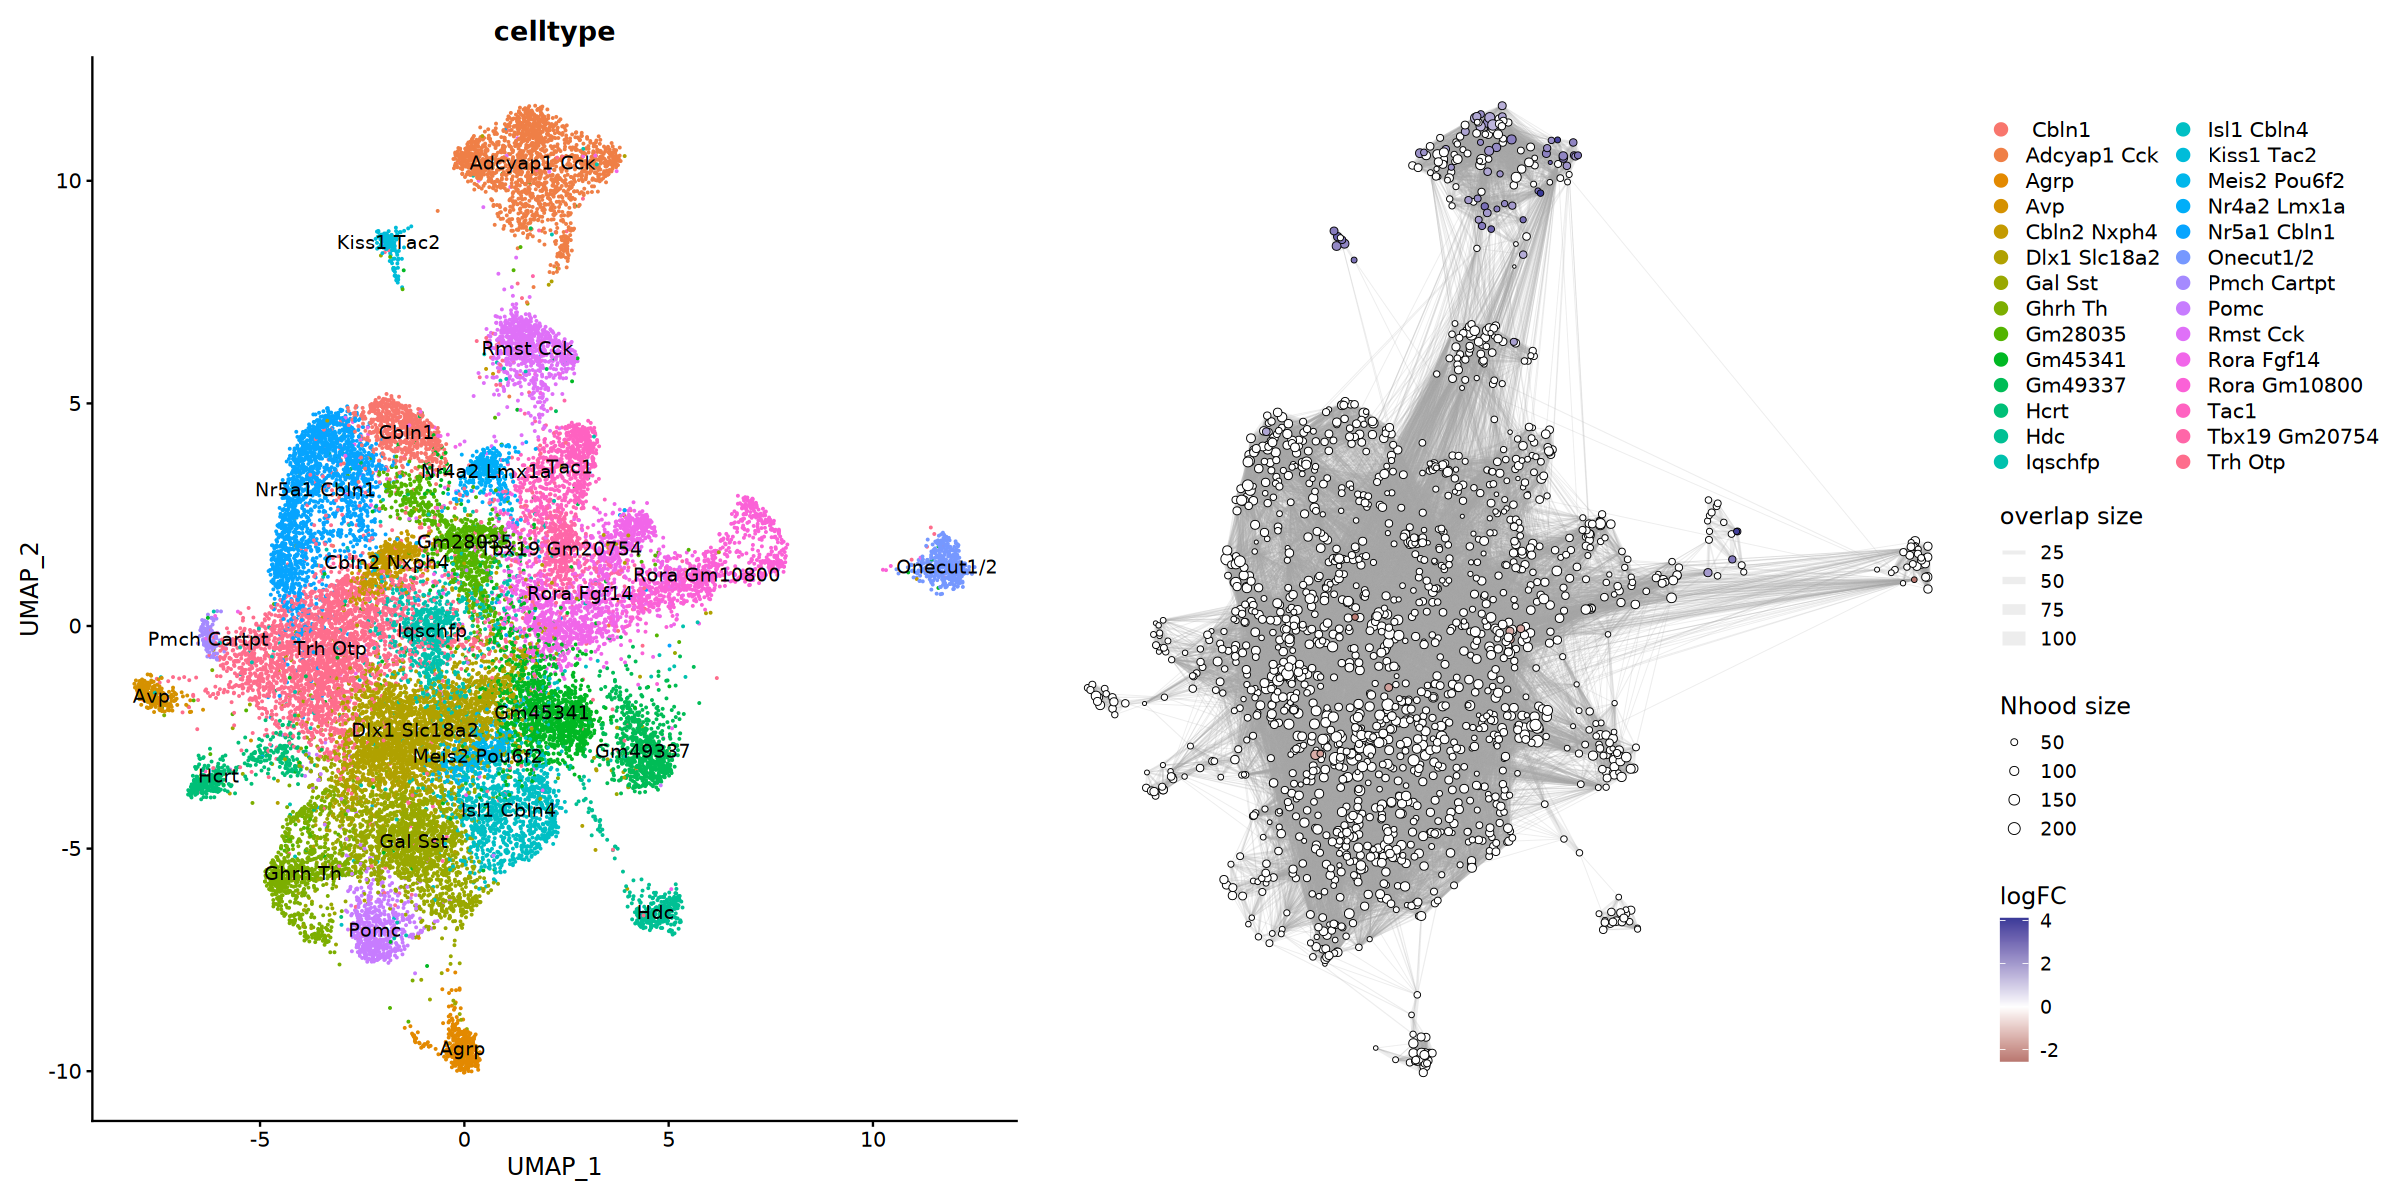

In [76]:
female_milo <- buildNhoodGraph(female_milo)
## Plot single-cell UMAP

umap_pl = DimPlot(female,group.by = 'celltype',label = T)
## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(female_milo, da_results,alpha=0.1)
options(repr.plot.width=20, repr.plot.height=10)
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [77]:
da_results <- annotateNhoods(female_milo, da_results, coldata_col = "celltype")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,celltype,celltype_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,0.41578387,9.758930,1.074031621,3.128915e-01,0.69714628,1,0.69682626,Pomc,1.0000000
2,-0.15998800,9.960917,0.165773986,6.883906e-01,0.92443266,2,0.92604420,Gm45341,0.9805825
3,0.26573201,8.269864,0.131566937,7.214037e-01,0.93295261,3,0.93474512,Cbln1,0.3333333
4,-0.00851495,9.856848,0.000430709,9.836560e-01,0.99488046,4,0.99490151,Dlx1 Slc18a2,0.6185567
5,2.44657071,9.827904,25.520226070,6.859133e-05,0.01050102,5,0.01216721,Kiss1 Tac2,1.0000000
6,0.33764730,8.992279,0.481380033,4.960979e-01,0.83734727,6,0.83872773,Rora Gm10800,1.0000000


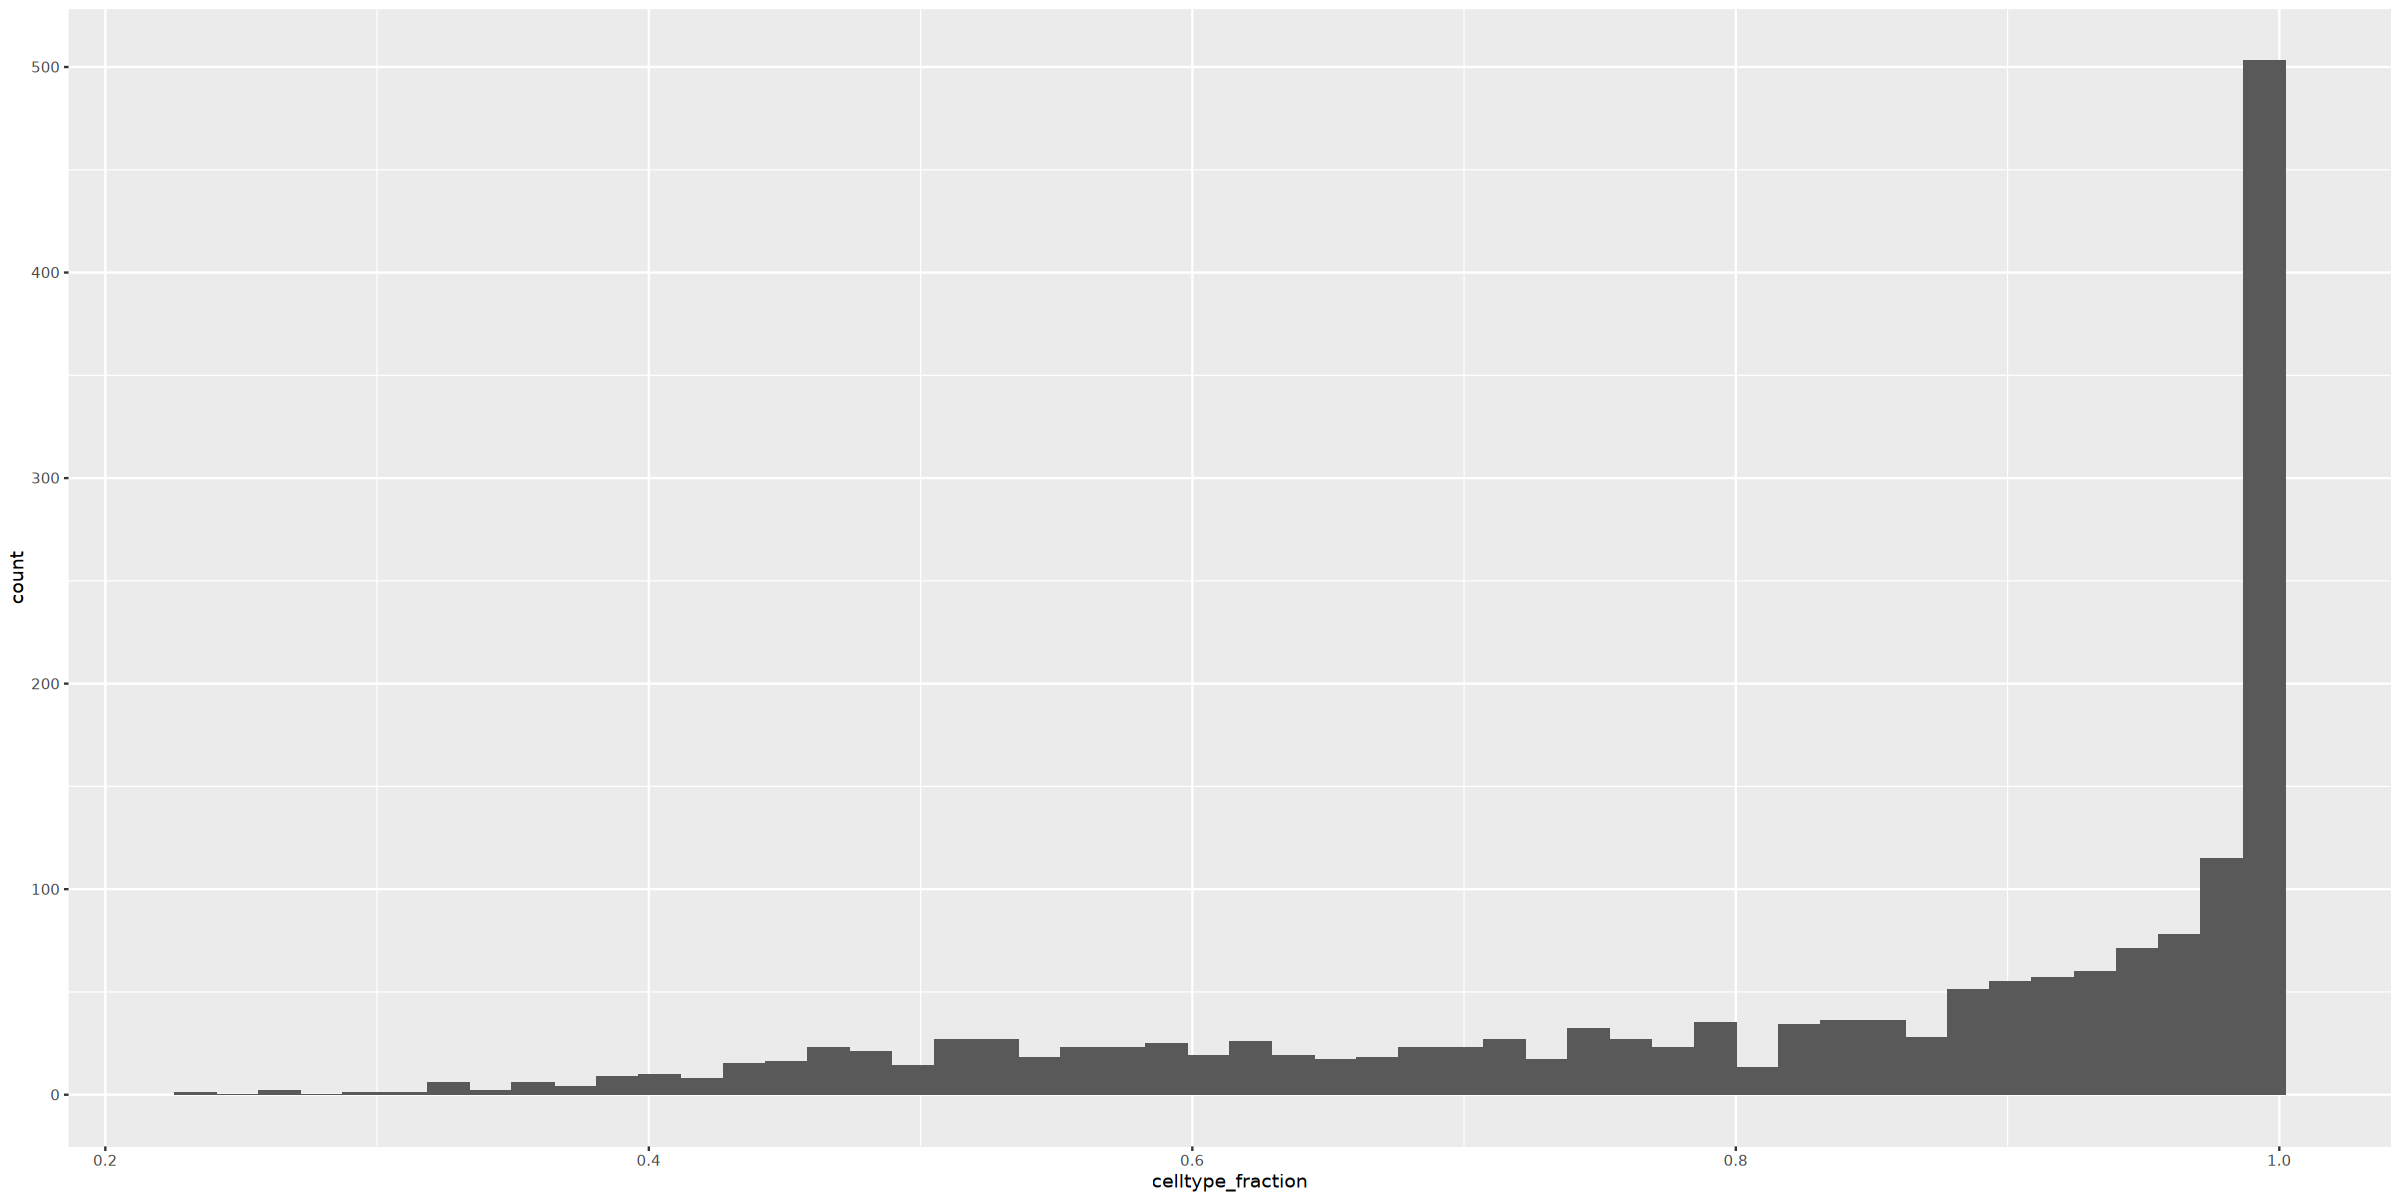

In [78]:
ggplot ( da_results , aes ( celltype_fraction )) + geom_histogram ( bins = 50 )

In [26]:
da_results$celltype = as.factor(da_results$celltype)

Converting group_by to factor...



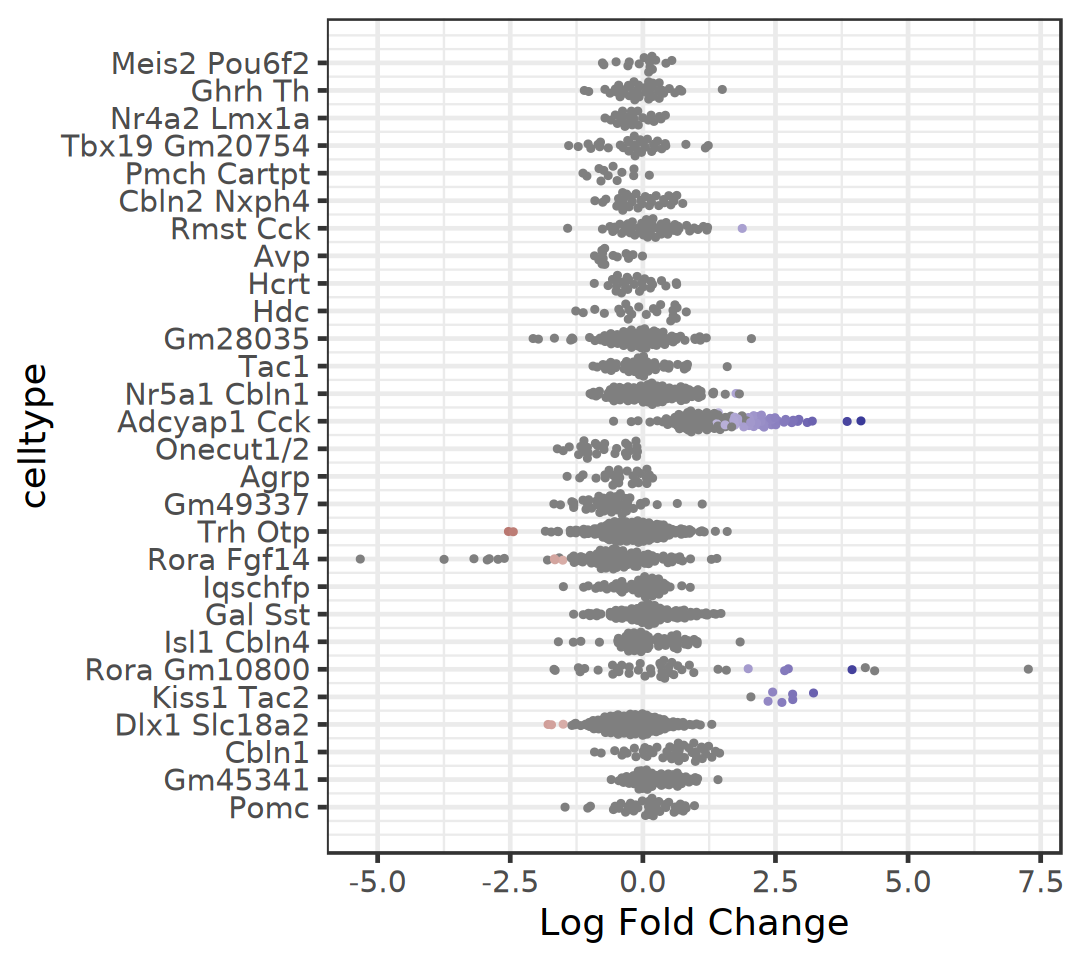

In [79]:
options(repr.plot.width=9, repr.plot.height=8)
plotDAbeeswarm(da_results, group.by = "celltype",alpha = 0.1)